# Example of running docking and scoring of ensitrelvir affinities in coronavirus targets

In [50]:
import warnings
from pathlib import Path
import pandas as pd
warnings.filterwarnings('ignore')

# Load OpenEye license from local directory (change to your own location), required by the drugforge package
!export OE_LICENSE=$HOME/Documents/.openeye/oe_license.txt

For this example, we will use a reference SARS-CoV-2 crystal in complex with ensitrelvir. The ligand will be docked into related coronavirus targets that infect humans. 

In [2]:
ref_pdb = "input_files/8dz0.pdb"

## 1. Sequence alignment

In this example, we perform a sequence-based search starting from a pdb file of SARS-CoV-2 in complex with Ensitrelvir (8dz0). This is done with `drugforge-spectrum seq-alignment` (See [documentation](https://asapdiscovery.readthedocs.io/en/latest/index.html) for instructions on how to use).

The sequence search is done by invoking the NCBI BLAST server over the internet, and it will take longer everytime a job is placed for a given sequence. Therefore, we advise to run the sequence alignment job only once and save the BLAST output as a .xml file for future runs. Below we provide the command for an initial sequence alignment job, starting from a pdb file (uncomment to use).

An email address is required the Entrez database system, which is used for retrieving information on viral hosts (for the filtering step of the alignment process). 

In [ ]:
#!drugforge-spectrum seq-alignment \
#        -f {ref_pdb} \
#        -t "pdb" \
#        --output-dir "data/sars2_alignment" \
#        --sel-key "host: Homo sapiens OR organism: human" \
#        --multimer --n-chains 2 \
#        --color-seq-match --plot-width 900 \
#        --max-mismatches 2 \
#        --email "your_email.org" # !! Replace with your email that will be used for Entrez (viral host search)

By default, the results from the BLAST search above are saved as `results.xml`. We provide this file in the `data/` directory. **After replacing the email argument**, the run below will generate the necessary files for the rest of the pipeline, along with a html visualization of the alignment. 

In [ ]:
!PYTHONWARNINGS="ignore" drugforge-spectrum seq-alignment \
        -f "input_files/results.xml" \
        -t "pre-calc" \
        --output-dir "data/sars2_alignment" \
        --sel-key "host: Homo sapiens OR organism: human" \
        --multimer --n-chains 2 \
        --color-seq-match --plot-width 900 \
        --max-mismatches 2 \
        --email "your_email.org" # !! Replace with your email that will be used for Entrez (viral host search)

## 2. ColabFold run to generate AlphaFold2 predicted models

The next step is folding the filtered sequences using the AlphaFold2 multimer model. This step requires a local installation of ColabFold so we provide an script to generate the data on the `data/` directory.

The script should look as follows:

```bash
#!/bin/bash
ref_pdb="input_files/8dz0.pdb"
csv_fn="data/sars2_alignment/SARS-CoV-2-Mpro.csv"
template_dir="data/template_dir_apo"
out_dir="data/sars2_alignment/cf_results_human_CoV/"

mkdir $template_dir
cp $ref_pdb $template_dir/0001.pdb

module load colabfold/v1.5.2

colabfold_batch $csv_fn $out_dir  \
 --num-recycle 3 --num-models 3 --model-type "alphafold2_multimer_v3" \
 --templates --custom-template-path $template_dir \
```


## 2.1. Structure alignment of ColabFold results

The next step is to extract the structures from the ColabFold run and align them to the reference target. The `drugforge-spectrum struct-alignment` module takes cares of this (see [documentation](https://drugforge.readthedocs.io/en/latest/) for instructions.)

The command below generates a folder with the aligned ligand-less structures `aligned_structures/`. We provide the ColabFold results folder in the `input_files/` directory as well.

In [ ]:
!PYTHONWARNINGS="ignore" drugforge-spectrum struct-alignment \
        -f "data/sars2_alignment/SARS-CoV-2-Mpro.csv" \
        --pdb-file {ref_pdb} \
        --output-dir "data/sars2_alignment/aligned_structures/" \
        --cfold-results "data/sars2_alignment/cf_results_human_CoV"\
        --color-by-rmsd \
        --cf-format "alphafold2_multimer_v3" 

## 3. Ligand transfer docking & minimization

The next step is to dock the ligand from the reference into the apo proteins. This is done by the `ligand-transfer-docking` command from `drugforge`. It takes the folder with aligned structures that we obtained in the previous step as an input, an will return the best pose of each target with the ligans in the reference protein, as well as a summary of the results in a csv file `docking_results_final.csv`. Refer to the `drugforge` documentation for more information.

It is advisable to prepare the proteins before running the docking to cap the termini and fill-in missing side chains. We provided a folder with 4 of the proteins from the previous step, prepared using Maestro. The command below will take a while to run. 

In [3]:
docking_results_dir = "data/transfer_docking_ensitrelvir"
docked_prep = "input_files/aligned_structures_p/"

In [ ]:
!PYTHONWARNINGS="ignore" drugforge-docking ligand-transfer-docking \
        --target SARS-CoV-2-Mpro \
        --structure-dir {docked_prep} \
        --ref-pdb-file {ref_pdb} \
        --output-dir {docking_results_dir} \
        --allow-retries --use-omega --omega-dense --allow-final-clash \
        --posit-confidence-cutoff 0.0 \
        --md \
        --md-steps 1 

## 4. Scoring of pose predictions 
Next, we refined the docking poses and score them. This is done by the `score_complexes.py` script included in the `scripts/` folder. The script takes a folder with the posed complexes as input, as well as the reference complex pdb.

From the `ligand-transfer-docking` run above, we need the pdbs of the poses and the results file. We extract the pdb file into a directory `data/docked_ensitrelvir/`, using a bash script (provided in `scripts/`), and then we run the scoring.

In [14]:
# Extract pdbs from ligand-ransfer-docking directory
protein_regex = "'YP_[0-9]+_[0-9]+|NP_[0-9]+_[0-9]+'" # pattern that matches the name of the targets
docked_dir = Path("data/minimized_ensitrelvir/")

!bash "scripts/copy_posed_pdbs.sh" {docking_results_dir} {docked_dir} {protein_regex}


mkdir: {docked_dir}: File exists


In this example run, we will minimize the pdbs to refine the docked poses first, and then we wil do the scoring. The script below will generate a ChemGauss4 score, ML scores (SchNet, E3NN and GAT) [**Coming soon**], Ligand RMSD and AutoDock Vina score. To generate gnina scores the `--gnina-score` command can be used, along with a script to run gnina via  `--gnina-script` and a directory to save the intermediate files in `--home-dir`. A couple of example gnina scripts are provided in `scripts/`, but a working installation of gnina is required. 

In [ ]:
!drugforge-spectrum score \
        -f {ref_pdb} \
        -d {docked_dir} \
        -o "data/score_results" \
        --docking-csv {docking_results_dir}/data_intermediates/docking_scores_filtered_sorted.csv \
        --target SARS-CoV-2-Mpro \
        --protein-regex {protein_regex} \
        --bsite-rmsd \
        --vina-score \
        --path-to-grid-prep "scripts/" \
        --dock-chain "1" --ref-chain "A" --lig-resname "LIG" \
        --log-level debug

Next, we calculate the PLIF scores using the scripts provided. This feature will be added to `drugforge-spectrum score` in a coming release.
First, we create a yaml file pointing to the directory containing the minimized protein-ligand complexes to score. This yaml file is used by `calculate_plip_interactions.py` to obtain the interactions, which prepares `csv` files to describe the interactions of each complex. Then, `run_plip_analysis.py` calculates the PLIF scores from those files. A CLI run is available, but here we will call the functions directly. 

In [71]:
# write yaml input file
import yaml
input_data = {
    "spectrum-ensitrelvir": f"{docked_dir}/"
}
yaml_file = "data/fp_ensit.yaml"
try:
    with open(yaml_file, 'w') as file:
        yaml.dump(input_data, file, sort_keys=False) 
    print(f"Data successfully written to '{yaml_file}'")
except Exception as e:
    print(f"An error occurred: {e}")

Data successfully written to 'data/fp_ensit.yaml'


In [72]:
# Calculate PLIFs 
import shutil
from scripts.calculate_plip_interactions import calculate_plip
from scripts.run_plip_analysis import get_plip_analysis

ref_pdb_min = Path("input_files/8dz0_min.pdb") # Minimized ref to compare with minimized complexes
shutil.copy2(ref_pdb_min, docked_dir)

plifs_dir = Path("data/fingerprints_ensit")
if plifs_dir.exists():
    shutil.rmtree(plifs_dir) # overwrite
calculate_plip(Path(yaml_file), 
                output_dir=plifs_dir,
                ncpus=1,
                ligand_id="UNK",
                error_log=plifs_dir/"plip_errors.log")

ref_csv = f"spectrum-ensitrelvir_{ref_pdb_min.stem}_interactions.csv"
df_plif = get_plip_analysis(crystal_csv=plifs_dir/ref_csv, 
                            docked_path=plifs_dir, 
                            output_dir=plifs_dir)

df_plif.head()

Loading all pdb structures in data/minimized_ensitrelvir
Analyzing 6 structures
Saved interactions to data/fingerprints_ensit/spectrum-ensitrelvir_8dz0_min_interactions.csv
Saved interactions to data/fingerprints_ensit/spectrum-ensitrelvir_YP_009944365_1_min_interactions.csv
Saved interactions to data/fingerprints_ensit/spectrum-ensitrelvir_NP_835346_1_min_interactions.csv
Saved interactions to data/fingerprints_ensit/spectrum-ensitrelvir_YP_009555250_1_min_interactions.csv
Saved interactions to data/fingerprints_ensit/spectrum-ensitrelvir_YP_010229075_1_min_interactions.csv
Saved interactions to data/fingerprints_ensit/spectrum-ensitrelvir_YP_009944273_1_min_interactions.csv
Successfully processed 6 structures for spectrum-ensitrelvir


,Structure,provenance,number_of_interactions_in_query,number_of_interactions_in_reference,number_of_interactions_in_intersection,number_of_interactions_in_union,tanimoto_coefficient,tversky_index,reference_fingerprint,query_fingerprint,ratio_of_intersection,ratio_of_query,Type of Interactions,Fingerprint Specificity
0,m-ensitrelvir_YP_010229075_1_min_interactions,ByTotalInteractions,9,10,9,1,0.9,0.9,{'TotalInteractions': 10},{'TotalInteractions': 9},0.9,0.9,Total Number of Interactions,Total Number of Interactions
1,m-ensitrelvir_YP_009944273_1_min_interactions,ByTotalInteractions,10,10,10,0,1.0,1.0,{'TotalInteractions': 10},{'TotalInteractions': 10},1.0,1.0,Total Number of Interactions,Total Number of Interactions
2,m-ensitrelvir_8dz0_min_interactions,ByTotalInteractions,10,10,10,0,1.0,1.0,{'TotalInteractions': 10},{'TotalInteractions': 10},1.0,1.0,Total Number of Interactions,Total Number of Interactions
3,m-ensitrelvir_NP_835346_1_min_interactions,ByTotalInteractions,10,10,10,0,1.0,1.0,{'TotalInteractions': 10},{'TotalInteractions': 10},1.0,1.0,Total Number of Interactions,Total Number of Interactions
4,m-ensitrelvir_YP_009555250_1_min_interactions,ByTotalInteractions,8,10,8,2,0.8,0.8,{'TotalInteractions': 10},{'TotalInteractions': 8},0.8,0.8,Total Number of Interactions,Total Number of Interactions


We get a dataframe listing all types of interactions in the reference and query, according to the following criteria:
1. By **total number** of interactions
2. By **type of interaction**
3. By both matching **type of interaction** and **type of residue** (i.e., ALA, LEU, etc.)
4. By both matching **type of interaction** and **type of atom** (i.e., C, N, etc.)
5. By matching **type of interaction**, **type of residue**, and whether the interaction is with the **backbone or sidechain**
6. By matching **type of interaction**, **type of residue**, and the **residue number**
7. Every condition combined

We use the *tversky_index* to quantify the similarity of the PLIFs according to the above criteria.

In the manuscript we focus on 1 and 3, so we add those two scores to the score dataframe we prepared earlier:

In [74]:
# We exclude the reference structure from the analysis
plif_filtered = df_plif[~df_plif['Structure'].str.contains(ref_pdb_min.stem)]

plif_filtered['prot-ID'] = plif_filtered['Structure'].str.extract(r'([YN]P_\d+_\d+)')
plif_all = plif_filtered.pivot(index="prot-ID", columns="provenance", values="tversky_index").reset_index()
plif_df = plif_all[['prot-ID', 'ByInteractionTypeAndResidueType','ByTotalInteractions']]

# The scores generated in the previous step
scores_all = pd.read_csv("data/score_results/scores.csv")

# Merge PLIFs scores                                                            
merged_df = scores_all.merge(
    plif_df, how='inner',
    on=['prot-ID']
)

merged_df

,prot-ID,premin-score-POSIT,docking-score-POSIT,Lig-RMSD,Bsite-RMSD,Vina-score-premin,Vina-score-min,ByInteractionTypeAndResidueType,ByTotalInteractions
0,YP_009944365_1,-3.972429,-8.987667,1.285646,1.257607,-9.511,-9.632,0.9,1.0
1,NP_835346_1,-1.480447,-7.030515,1.855002,5.803271,-8.733,-8.750,0.5,1.0
2,YP_009555250_1,-3.931815,-11.252013,1.316985,2.010962,-9.681,-10.118,0.7,0.8
3,YP_010229075_1,-3.507752,-11.023062,1.353741,1.405026,-9.034,-9.702,0.5,0.9
4,YP_009944273_1,-4.314525,-10.758464,1.036090,1.344663,-9.724,-9.613,0.7,1.0


# Plotting the results
Now we will plot the scores generated in the previous step. We have included a csv file with all the scores, including those using AutoDock Vina and Gnina in the `data/` directory for reference, and we will use those for the plotting. We also added a column for `'blast-descriptor'` and `'blast-score'` using the data from `blast.csv` produced in the sequence alignment step. 

In [ ]:
# Import all the required modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scripts.plot_results import (
    plot_bar_scores_in_df, 
    plot_score_correlation, 
    plot_stacked_correlations,
    scatter_scores, 
    get_roc_curve, 
    get_conf_mat,
    bootstrap_auc
)


We import the csv as a pandas DataFrame

In [ ]:
df_scores = pd.read_csv("data/ensitrelvir_scores.csv") 
print(df_scores.head())

          prot-ID  gnina-RMSD  gnina-dock-Affinity  gnina-Affinity-var  \
0     NP_835346_1      0.3683              -9.8820             -0.9099   
1  YP_001718611_1      0.5179              -8.9478             -0.9146   
2  YP_002308478_1      0.6986              -9.3604             -0.6978   
3  YP_005352862_1      0.8092              -9.2297             -1.0152   
4  YP_008439216_1      0.5097             -10.6673             -0.9464   

   CNN_dock_score  CNN_dock_affinity  premin-score-POSIT  docking-score-POSIT  \
0          0.3786             7.0892           -2.265110           -10.109201   
1          0.3047             7.0430           -4.637259           -11.285685   
2          0.0875             6.5198            8.447901            -8.899652   
3          0.3832             6.9464            8.869884            -7.681045   
4          0.7628             7.8320           -6.364501           -11.328412   

   computed-SchNet-pIC50  computed-E3NN-pIC50  computed-GAT-pIC50  L

The experimental signal is provided in the `data/` directory as a `csv` file. This data corresponds to the recovery signal compared to a DMSO background, from a cellular assay of ensitrelvir on a coronavirus panel (from this [reference paper](https://journals.asm.org/doi/full/10.1128/jvi.00597-23)). We convert the signal by substracting it to the DMSO reference of 100, such that it is proportional to the strength of ensitrelvir against each target, and add a second column labeling whether the ligand is *active*, *partial* or *inactive* against the target.

In [ ]:
df_signal = pd.read_csv("data/sars_ensit_signal.csv")
df_all = df_scores.merge(df_signal[['prot-ID','signal']], how = 'inner', on = ['prot-ID'])
df_all['signal'] = df_all['signal'].apply(lambda x: 100-x)
df_all["Activity"] = df_all["signal"].apply(lambda x: "active" if x > 50 else "partial" if x > 30 else "inactive")
df_all.reset_index(drop=True, inplace=True)
print(df_all[['prot-ID', 'signal', 'Activity']])

           prot-ID  signal  Activity
0      NP_835346_1      10  inactive
1   YP_001718611_1       0  inactive
2   YP_002308478_1       4  inactive
3   YP_005352862_1       1  inactive
4   YP_008439216_1       0  inactive
5   YP_009047217_1      82    active
6   YP_009336483_1       0  inactive
7   YP_009513020_1       0  inactive
8   YP_009555250_1       0  inactive
9   YP_009725295_1     100    active
10  YP_009924387_1       0  inactive
11  YP_009944273_1      33   partial
12  YP_009944365_1      88    active
13  YP_010037473_1       0  inactive
14  YP_010037559_1      10  inactive
15  YP_010229075_1      10  inactive


Read fingerprint score data

In [ ]:
plif_scores = pd.read_csv("data/fingerprint_scores.csv", index_col=0)
plif_scores['Structure'] = plif_scores['Structure'].str.extract(r'^(YP_\d+_\d+|NP_\d+_\d+)')
plif_scores = plif_scores.rename(columns={'Structure':'prot-ID'})
plif_all = plif_scores.pivot(index="prot-ID", columns="provenance", values="tversky_index").reset_index()
plif_all.drop(columns=['ByEverything', 'ByInteractionType'], inplace=True)
df_wfingerprint = df_all.merge(plif_all, how = 'inner', on = ['prot-ID'])

Calculate binding site similarity

In [ ]:
from scripts.structure_compare import calculate_bsite_score
from Bio import AlignIO
sars2_alignment = "input_files/sars2_alignment/SARS-CoV-2-Mpro_alignment.fasta"
alignment = AlignIO.read(sars2_alignment, "fasta")
pdb_dir = "input_files/docked_minimized_ensitrelvir_all/"
ref_pdb = "input_files/8dz0_min.pdb"
prot_id, seq_score, matching_res = calculate_bsite_score(alignment, ref_pdb, pdb_dir, ref_idx=0, 
                                                        chain_mob='1', chain_ref='1', lig_mob='UNK', lig_ref='UNK',)
df = pd.DataFrame({'prot-ID': prot_id, 'Bsite-seq-identity': np.round(seq_score,2), 'matching-bsite-res': matching_res})
df_all = df_wfingerprint.merge(df, how = 'inner', on = ['prot-ID'])

PDB wasn't found for label YP_001876436_1


Load pre-computed Boltz-2 and Chai-1 results

In [ ]:
df_all_b = pd.read_csv("data/boltz2_ensit_results.csv")
df_all_c = pd.read_csv("data/chai1_ensit_results.csv")

df_all_b = df_all_b.rename(columns={'CNNaffinity':'CNN_dock_affinity', 'CNNscore':'CNN_dock_score'})
df_all_c = df_all_c.rename(columns={'CNNaffinity':'CNN_dock_affinity', 'CNNscore':'CNN_dock_score'})

df_all_b['Lig-RMSD'] = df_all_b['Lig-RMSD'].replace(-1, 10)
df_all_b['RMSD'] = 1/(1+df_all_b['Lig-RMSD'])

df_all_c['Lig-RMSD'] = df_all_c['Lig-RMSD'].replace(-1, 10)
df_all_c['RMSD'] = 1/(1+df_all_c['Lig-RMSD'])

First, we will plot all of the relevant scores calculated in a bar plot, with the scores re-scaled from 0 to 1.

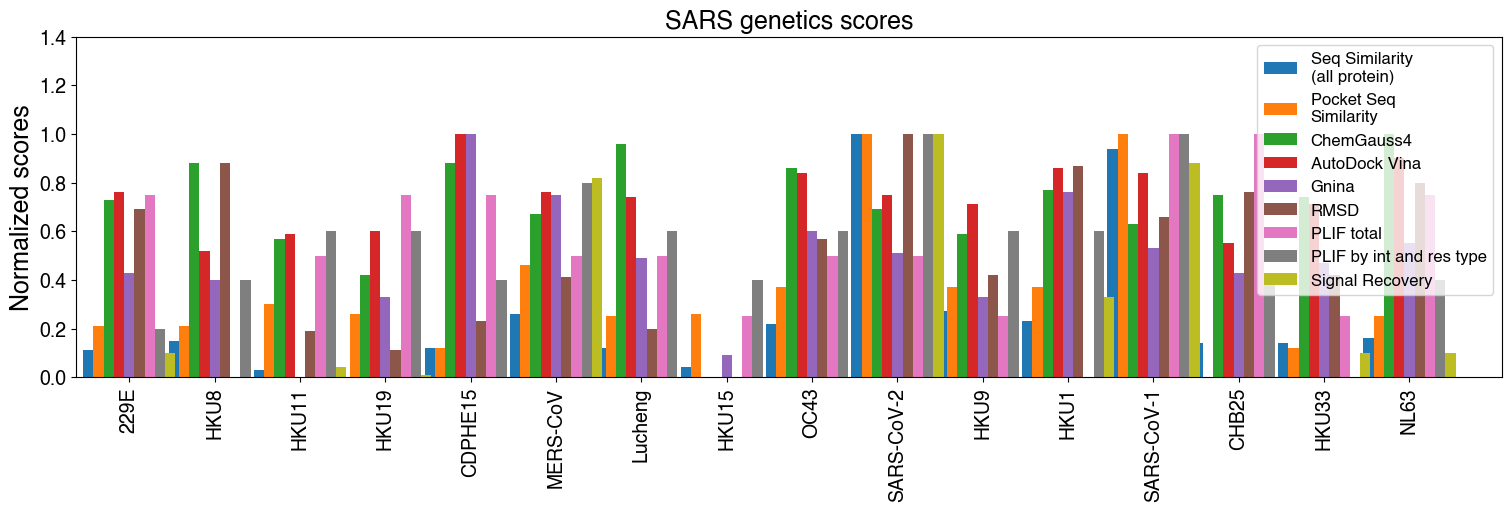

In [ ]:
col_labels = ['blast-scores', 
              'Bsite-seq-identity',
              'docking-score-POSIT', 
              'Vina-score-premin', 
              'CNN_dock_affinity',
              'RMSD',
              'ByTotalInteractions',
              'ByInteractionTypeAndResidueType',
              'signal', 
              ]
score_labels = ['Seq Similarity\n(all protein)',
                'Pocket Seq\nSimilarity',
                'ChemGauss4', 
                'AutoDock Vina', 
                'Gnina', 
                'RMSD',
                'PLIF total',
                'PLIF by int and res type',
                'Signal Recovery']
sign_list = [1,1,-1,-1,1,1,1,1,1,1]
df_all['Lig-RMSD'] = df_all['Lig-RMSD'].replace(-1, 10)
df_all['RMSD'] = 1/(1+df_all['Lig-RMSD'])
fig = plot_bar_scores_in_df(df_all, target_labels=df_all['blast-descriptor'], 
                            label_cols=col_labels, sign_list=sign_list, 
                            score_labels=score_labels,
                            title='SARS genetics scores', yrange=[0, 1.4], 
                            ylabel='Normalized scores', figsize=(15,5.), label_bars=False, bar_width=0.12)

It is important to observe the correlation between different scores, especially, with respect to the experimental *Signal Inhibition*. We compare the correlation of each score with the experimental signal on a bar plot.

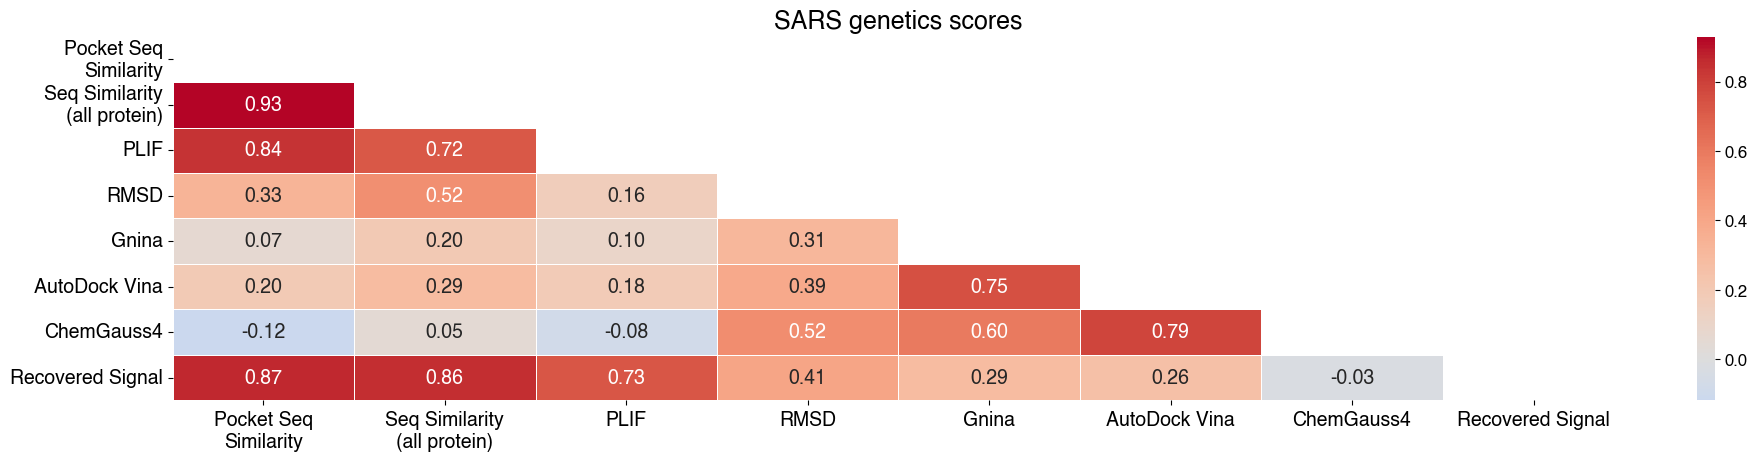

In [ ]:
df = df_all.copy()
df = df[['Bsite-seq-identity', 'blast-scores', 'ByInteractionTypeAndResidueType', 'RMSD', 'CNN_dock_affinity', 'Vina-score-premin', 'docking-score-POSIT', 'signal',]]
df['docking-score-POSIT'] = df['docking-score-POSIT'].apply(lambda x: -x)
df['Vina-score-premin'] = df['Vina-score-premin'].apply(lambda x: -x)
df = df.rename(columns={'blast-scores': 'Seq Similarity\n(all protein)', 'Bsite-seq-identity': 'Pocket Seq\nSimilarity', 
                        'ByInteractionTypeAndResidueType': 'PLIF', 'docking-score-POSIT': 'ChemGauss4', 'Vina-score-premin': 'AutoDock Vina', 
                        'CNN_dock_affinity': 'Gnina', 
                        'signal': 'Recovered Signal'})
fig = plot_score_correlation(df, 'blast-descriptor', 'signal', 'SARS genetics scores', [-0.05, 1.05], 'Signal Inhibition', 'Normalized scores',
                  figsize=(17.5,4.5), type='heatmap')

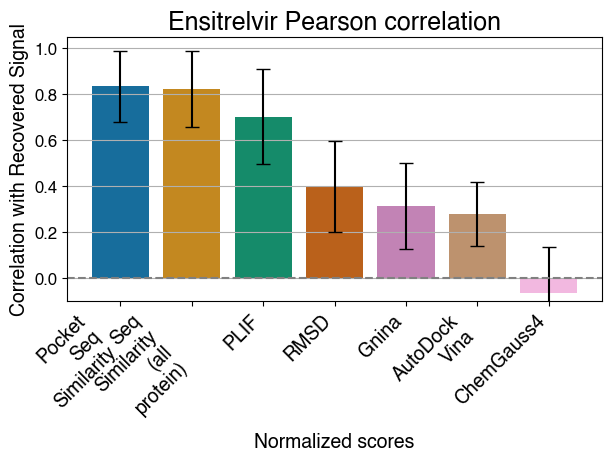

In [ ]:
fig, ax = plot_score_correlation(df, 'blast-descriptor', 'Recovered Signal', 'Ensitrelvir Pearson correlation', yrange=[-0.1, 1.05], ylabel='Signal Inhibition', xlabel='Normalized scores',
                  figsize=(6,4.5), type='bars', error_type='var', color_palette='colorblind', correlation='Pearson')

Pearson and Kendall's Tau correlation

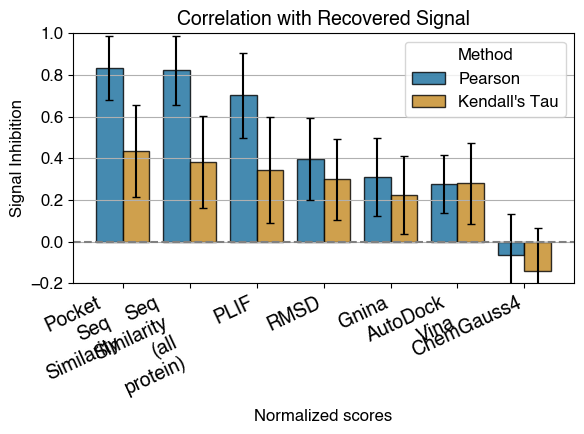

In [ ]:
fig, ax = plot_stacked_correlations(df, 'Recovered Signal', yrange=[-0.2, 1.], ylabel='Signal Inhibition', xlabel='Normalized scores', color_palette='colorblind',
                  figsize=(6,4.5))

Below, a scatter plot shows the correlation between the experimental signal and three different scores: The *AutoDock Vina* and *Gnina* scores and the sequence similarity (*BLAST score*). The points are colored by activity (**red**=Active, **red**=Partial, **blue**=Inactive).

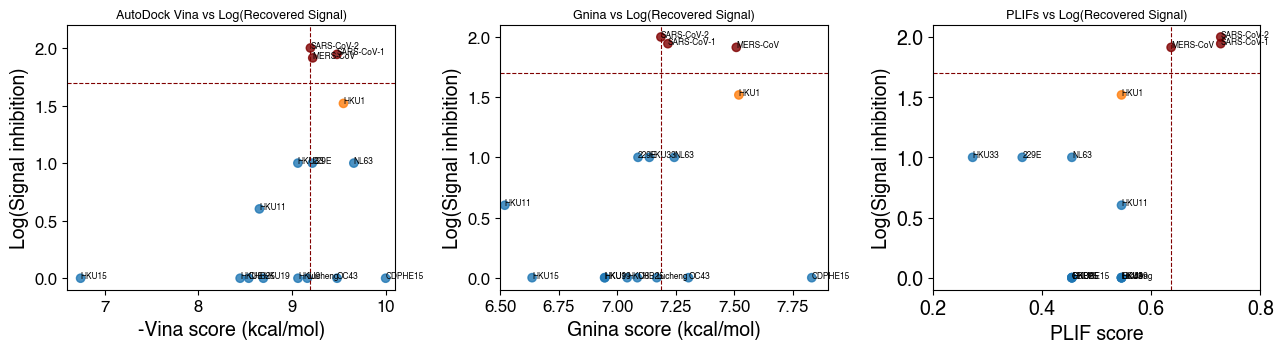

In [ ]:
signal = np.log10(df_all['signal'])
signal[signal == -np.inf] = 0
true_actives = df_all[df_all['Activity'] == 'active']

fig, axs = plt.subplots(1, 3, figsize=(13,3.7))

ax1 = scatter_scores(axs[0], -df_all['Vina-score-premin'], signal,
                    '-Vina score (kcal/mol)', 'Log(Signal inhibition)',title='AutoDock Vina vs Log(Recovered Signal)',
                    ylim=(-0.1, 2.2), xlim=(6.6, 10.1), point_labels=df_all["blast-descriptor"],  hue=df_all['Activity'], linear=False)
ax1.axline((0, np.log10(50)), slope=0, color='maroon', linestyle='--', linewidth=0.8)
ax1.axvline(min(-true_actives['Vina-score-premin']), color='maroon', linestyle='--', linewidth=0.8)

ax2 = scatter_scores(axs[1], df_all['CNN_dock_affinity'], signal,
                    'Gnina score (kcal/mol)', 'Log(Signal inhibition)', title='Gnina vs Log(Recovered Signal)',
                    ylim=(-0.1, 2.1), xlim=(6.5, 7.9), point_labels=df_all["blast-descriptor"], hue=df_all['Activity'], linear=False)
ax2.axline((0, np.log10(50)), slope=0, color='maroon', linestyle='--', linewidth=0.8)
ax2.axvline(min(true_actives['CNN_dock_affinity']), color='maroon', linestyle='--', linewidth=0.8)

ax3 = scatter_scores(axs[2], df_all['ByInteractionTypeAndResidueType'], signal,
                    'PLIF score', 'Log(Signal inhibition)', title='PLIFs vs Log(Recovered Signal)',
                    ylim=(-0.1, 2.1), xlim=(0.2, 0.8), point_labels=df_all["blast-descriptor"], hue=df_all['Activity'], linear=False)
ax3.axline((0, np.log10(50)), slope=0, color='maroon', linestyle='--', linewidth=0.8)
ax3.axvline(min(true_actives['ByInteractionTypeAndResidueType']), color='maroon', linestyle='--', linewidth=0.8)
plt.tight_layout()

We can also plot the confusion matrix for different scores, to visualize how accurate or scores can classify ligand activity across the different coronaviruses. The classification is done by setting an inhibition criteria that includes both *Partial* and *Active* categories (top row) and only *Active* (bottom row).

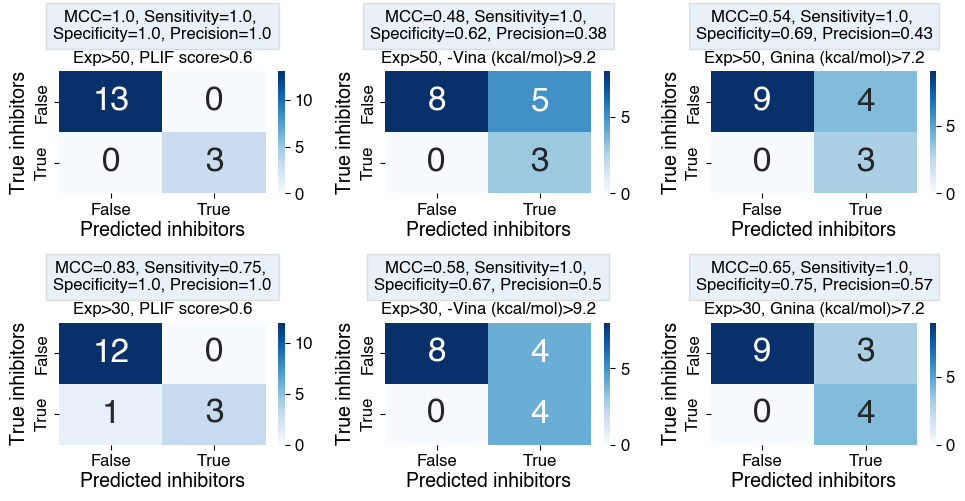

In [ ]:
true_actives = df_all[df_all['Activity'] == 'active']
true_actives_ext = df_all[df_all['Activity'].isin(['active','partial'])]

fig, axs = plt.subplots(2, 3, figsize=(10, 5.2))
ax2 = get_conf_mat(axs[0, 0], df_all['ByInteractionTypeAndResidueType'], df_all['signal'], min(true_actives['ByInteractionTypeAndResidueType']), 50, 'PLIF score')
ax1 = get_conf_mat(axs[1, 0], df_all['ByInteractionTypeAndResidueType'], df_all['signal'], min(true_actives['ByInteractionTypeAndResidueType']), 30, 'PLIF score')

ax2 = get_conf_mat(axs[0, 1], -df_all['Vina-score-premin'], df_all['signal'], min(-true_actives['Vina-score-premin']), 50, '-Vina (kcal/mol)')
ax1 = get_conf_mat(axs[1, 1], -df_all['Vina-score-premin'], df_all['signal'], min(-true_actives['Vina-score-premin']), 30, '-Vina (kcal/mol)')

ax2 = get_conf_mat(axs[0, 2], df_all['CNN_dock_affinity'], df_all['signal'], min(true_actives['CNN_dock_affinity']), 50, 'Gnina (kcal/mol)')
ax1 = get_conf_mat(axs[1, 2], df_all['CNN_dock_affinity'], df_all['signal'], min(true_actives['CNN_dock_affinity']), 30, 'Gnina (kcal/mol)')

fig.subplots_adjust(hspace=1)
fig.tight_layout()

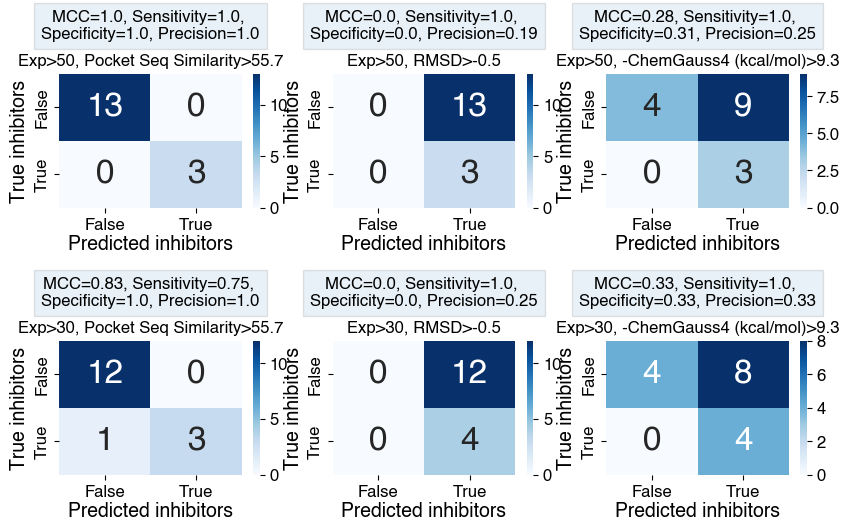

In [ ]:
true_actives = df_all[df_all['Activity'] == 'active']
true_actives_ext = df_all[df_all['Activity'].isin(['active','partial'])]

fig, axs = plt.subplots(2, 3, figsize=(10, 5.2))
ax2 = get_conf_mat(axs[0, 0], df_all['Bsite-seq-identity'], df_all['signal'], min(true_actives['Bsite-seq-identity']), 50, 'Pocket Seq Similarity')
ax1 = get_conf_mat(axs[1, 0], df_all['Bsite-seq-identity'], df_all['signal'], min(true_actives['Bsite-seq-identity']), 30, 'Pocket Seq Similarity')

ax2 = get_conf_mat(axs[0, 1], -df_all['RMSD'], df_all['signal'], min(-true_actives['RMSD']), 50, 'RMSD')
ax1 = get_conf_mat(axs[1, 1], -df_all['RMSD'], df_all['signal'], min(-true_actives['RMSD']), 30, 'RMSD')

ax2 = get_conf_mat(axs[0, 2], -df_all['docking-score-POSIT'], df_all['signal'], min(-true_actives['docking-score-POSIT']), 50, '-ChemGauss4 (kcal/mol)')
ax1 = get_conf_mat(axs[1, 2], -df_all['docking-score-POSIT'], df_all['signal'], min(-true_actives['docking-score-POSIT']), 30, '-ChemGauss4 (kcal/mol)')

fig.subplots_adjust(hspace=1)

Finally, the most useful metric for a scoring approach at an early stage of the durg discovery pipeline, is the ROC curve, which can indicate to potential of our model to rank molecules. The AUC score is calculated through a bootstrap sampling, which allows is to calculate the uncertainty of the measure.

AUC is 0.95, with bootstrap-sampling is 0.947+/-0.049
95% Confidence Interval: [0.85, 1.00]
AUC is 1.0, with bootstrap-sampling is 1.0+/-0.0
95% Confidence Interval: [1.00, 1.00]
********
AUC is 0.31, with bootstrap-sampling is 0.299+/-0.134
95% Confidence Interval: [0.07, 0.61]
AUC is 0.4, with bootstrap-sampling is 0.4+/-0.129
95% Confidence Interval: [0.11, 0.67]
********
AUC is 0.83, with bootstrap-sampling is 0.838+/-0.111
95% Confidence Interval: [0.58, 1.00]
AUC is 0.74, with bootstrap-sampling is 0.736+/-0.148
95% Confidence Interval: [0.46, 0.98]


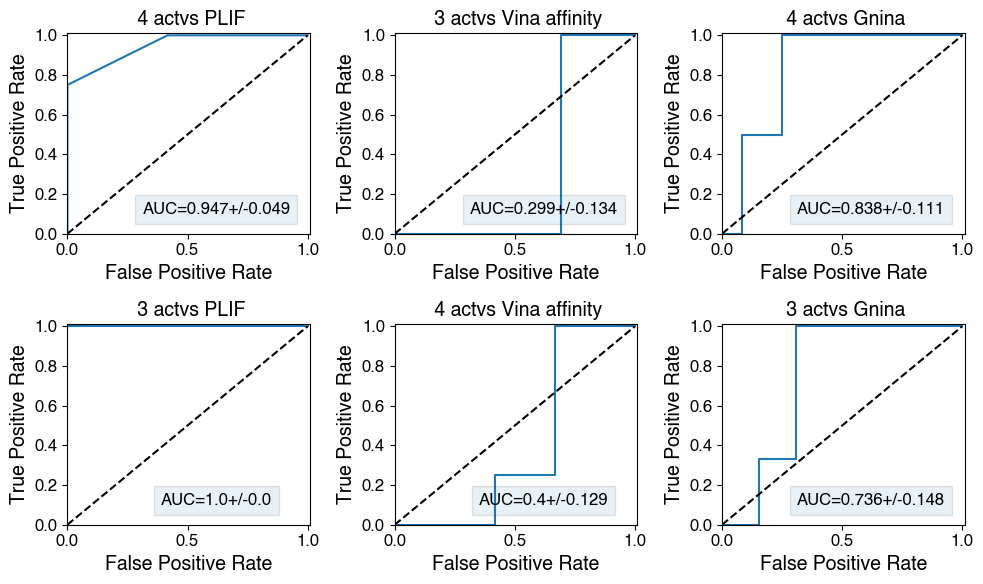

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(10, 6))

title = lambda x: f" {np.count_nonzero(df_all['signal']>x)} actvs"

ax1 = get_roc_curve(axs[0,0], df_all['ByInteractionTypeAndResidueType'], df_all['signal'] > 30, pred_type='PLIF', title=title(30), n_bootstraps=100)
ax2 = get_roc_curve(axs[1,0], df_all['ByInteractionTypeAndResidueType'], df_all['signal'] > 50, pred_type='PLIF', title=title(50), n_bootstraps=10)
print('********')

ax2 = get_roc_curve(axs[0,1], -df_all['docking-score-POSIT'], df_all['signal'] > 50, pred_type='Vina affinity', title=title(50), n_bootstraps=100)
ax2 = get_roc_curve(axs[1,1], -df_all['docking-score-POSIT'], df_all['signal'] > 30, pred_type='Vina affinity', title=title(30), n_bootstraps=100)
print('********')
ax1 = get_roc_curve(axs[0,2], df_all['CNN_dock_affinity'].fillna(0), df_all['signal'] > 30,  pred_type='Gnina', title=title(30), n_bootstraps=100)
ax2 = get_roc_curve(axs[1,2], df_all['CNN_dock_affinity'].fillna(0), df_all['signal'] > 50,  pred_type='Gnina', title=title(50), n_bootstraps=100)

plt.tight_layout()

We can also visualize different scores in the same plot to compare their performance,

Pocket Seq
Similarity Bsite-seq-identity
AUC is 1.0, with bootstrap-sampling is 1.0+/-0.0
95% Confidence Interval: [1.00, 1.00]
Seq Similarity
(all protein) blast-scores
AUC is 0.97, with bootstrap-sampling is 0.977+/-0.039
95% Confidence Interval: [0.90, 1.00]
PLIF ByInteractionTypeAndResidueType
AUC is 1.0, with bootstrap-sampling is 1.0+/-0.0
95% Confidence Interval: [1.00, 1.00]
RMSD RMSD
AUC is 0.67, with bootstrap-sampling is 0.667+/-0.192
95% Confidence Interval: [0.28, 1.00]
Gnina CNN_dock_affinity
AUC is 0.74, with bootstrap-sampling is 0.736+/-0.134
95% Confidence Interval: [0.46, 0.96]
AutoDock Vina Vina-score-premin
AUC is 0.67, with bootstrap-sampling is 0.662+/-0.143
95% Confidence Interval: [0.38, 0.92]
ChemGauss4 docking-score-POSIT
AUC is 0.31, with bootstrap-sampling is 0.301+/-0.126
95% Confidence Interval: [0.08, 0.58]


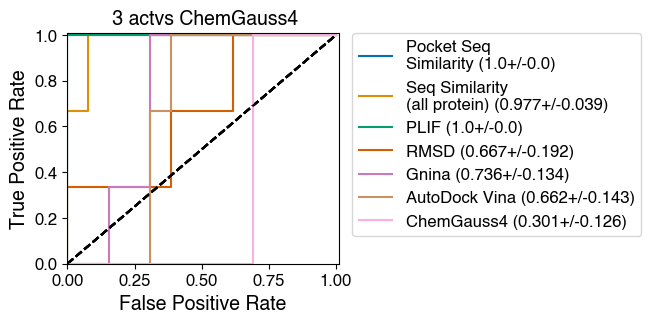

In [ ]:
import seaborn as sns
fig, axs = plt.subplots(1, 1, figsize=(3.5, 3))

labels = ['Pocket Seq\nSimilarity', 'Seq Similarity\n(all protein)', 'PLIF', 'RMSD', 'Gnina', 'AutoDock Vina', 'ChemGauss4', ]
cols = ['Bsite-seq-identity', 'blast-scores', 'ByInteractionTypeAndResidueType', 'RMSD', 'CNN_dock_affinity', 'Vina-score-premin', 'docking-score-POSIT'] 

signs = [1]*len(labels)
signs[-2] *= -1
signs[-1] *= -1
colors = list(sns.color_palette("colorblind"))
title = lambda x: f" {np.count_nonzero(df_all['signal']>x)} actvs"
for label, col, color, sign in zip(labels, cols, colors, signs):
    print(label, col)
    ax1 = get_roc_curve(axs, df_all[col]*sign, df_all['signal'] > 50, pred_type=label, title=title(50), n_bootstraps=300, color=color, box=False, legend=True)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()

And with 4 actives (including the *partial*)

Pocket Seq
Similarity Bsite-seq-identity
AUC is 0.98, with bootstrap-sampling is 0.982+/-0.022
95% Confidence Interval: [0.93, 1.00]
Seq Similarity
(all protein) blast-scores
AUC is 0.96, with bootstrap-sampling is 0.964+/-0.048
95% Confidence Interval: [0.84, 1.00]
PLIF ByInteractionTypeAndResidueType
AUC is 0.95, with bootstrap-sampling is 0.947+/-0.049
95% Confidence Interval: [0.85, 1.00]
RMSD RMSD
AUC is 0.75, with bootstrap-sampling is 0.757+/-0.167
95% Confidence Interval: [0.37, 1.00]
Gnina CNN_dock_affinity
AUC is 0.83, with bootstrap-sampling is 0.838+/-0.111
95% Confidence Interval: [0.58, 1.00]
AutoDock Vina Vina-score-premin
AUC is 0.75, with bootstrap-sampling is 0.75+/-0.132
95% Confidence Interval: [0.47, 1.00]
SchNet computed-SchNet-pIC50
AUC is 0.65, with bootstrap-sampling is 0.64+/-0.209
95% Confidence Interval: [0.15, 1.00]
ChemGauss4 docking-score-POSIT
AUC is 0.4, with bootstrap-sampling is 0.4+/-0.129
95% Confidence Interval: [0.11, 0.67]


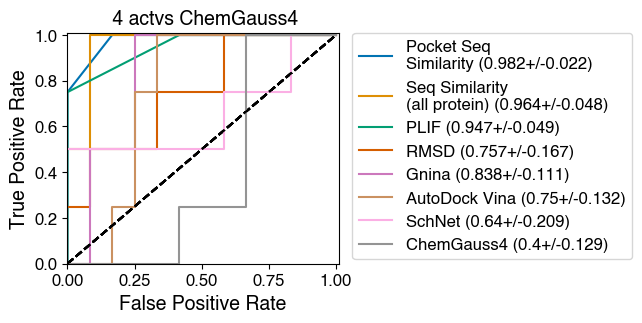

In [ ]:
import seaborn as sns
fig, axs = plt.subplots(1, 1, figsize=(3.5, 3))

labels = ['Pocket Seq\nSimilarity', 'Seq Similarity\n(all protein)', 'PLIF', 'RMSD', 'Gnina', 'AutoDock Vina', 'SchNet', 'ChemGauss4'] 
cols = ['Bsite-seq-identity', 'blast-scores', 'ByInteractionTypeAndResidueType', 'RMSD', 'CNN_dock_affinity', 'Vina-score-premin', 'computed-SchNet-pIC50', 'docking-score-POSIT']
signs = [1]*len(labels)
signs[5] *= -1
signs[-1] *= -1
colors = list(sns.color_palette("colorblind"))
title = lambda x: f" {np.count_nonzero(df_all['signal']>x)} actvs"
for label, col, color, sign in zip(labels, cols, colors, signs):
    print(label, col)
    ax1 = get_roc_curve(axs, df_all[col]*sign, df_all['signal'] > 30, pred_type=label, title=title(30), n_bootstraps=100, color=color, box=False, legend=True)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()

Also, plot the AUC scores as bar plots for easier visualization

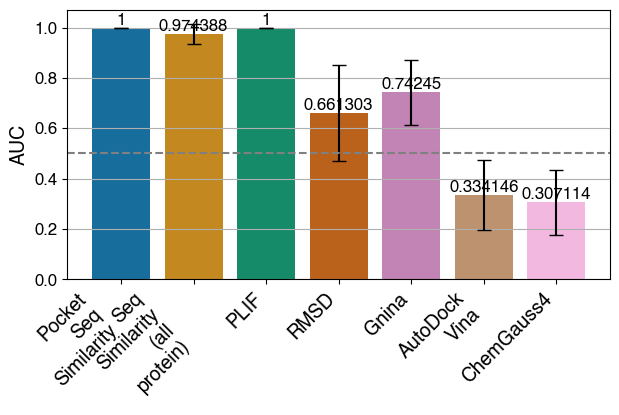

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 3.5))

error_type = 'var'
def extract_auc_stats(df, exp_col):
    df_num = df.select_dtypes(include=["number"])

    y_true = df[exp_col] > 50        
    stats = {}
    for col in df_num.columns:
        if col != exp_col:
            y_score = df[col] 
            if 'Vina' in col or 'POSIT' in col:
                y_score = -df[col]  # Negate ChemGauss and Vina scores
            mean_auc, standard_error, ci_lower, ci_upper = bootstrap_auc(
                y_score, y_true, n_bootstraps=500)
            
            stats[col] = {"mean": mean_auc, "stderr": standard_error,
                        "ci_low": ci_lower, "ci_high": ci_upper}
    return stats

stats = extract_auc_stats(df, 'Recovered Signal')
df_corr = pd.DataFrame([{
"feature": f.replace(" ", "\n"),
"auc": v["mean"],
"yerr": v["stderr"],
"err_low": v["mean"] - v["ci_low"],
"err_up": v["ci_high"] - v["mean"]
} for f, v in stats.items()])


p = sns.barplot(data=df_corr, x="feature", y="auc",
            palette='colorblind', errorbar=None, ax=ax)
# Add manual error bars
for i, row in df_corr.iterrows(): 
    if error_type == "CI":
        error = [[row["err_low"]], [row["err_up"]]]
    elif error_type == "var":
        error = row["yerr"]
    else: 
        raise NotImplementedError(f"Error type {error_type} not implemented. Use 'CI' or 'var'") 
    ax.errorbar(i, row["auc"], yerr=error, fmt='none', color='black', capsize=5)

ax.set_xticklabels(
    ax.get_xticklabels(), rotation=45, ha="right", fontsize=14
)  

for container in ax.containers[:7]:
    ax.bar_label(container)

ax.axhline(0.5, color="gray", linestyle="dashed")  # Add reference line at 0
ax.set_xlabel("")
ax.set_ylabel(f"AUC", fontsize=14)
ax.set_ylim(0, 1.07)
ax.grid(axis='y')


### Comparing with different co-folding methods

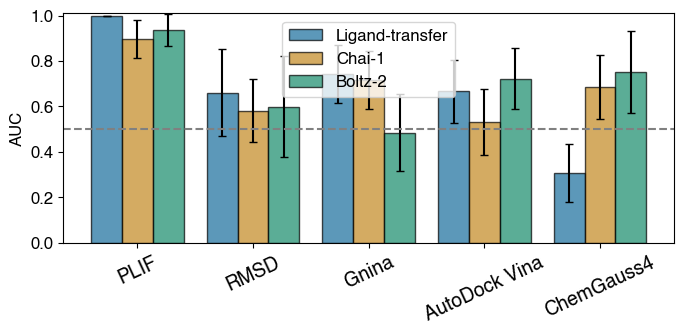

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(7, 3.5))

datasets = [df_all, df_all_c, df_all_b,]
ligands = [
    "Ligand-transfer",
    "Chai-1",
    "Boltz-2",
]
labels = ['PLIF', 'RMSD', 'Gnina', 'AutoDock Vina', 'ChemGauss4']
feature_cols = ['ByInteractionTypeAndResidueType', 'RMSD', 'CNN_dock_affinity', 'Vina-score-premin','docking-score-POSIT']

df_list = []

colors = sns.color_palette("colorblind", n_colors=len(ligands))
color_map = dict(zip(labels, colors))

# Plot ROC curves
for label, col, in zip(labels, feature_cols): 

    for dataset, color, ligand in zip(datasets, colors, ligands):
        y_true = dataset['signal'] > 50
        y_score = dataset[col]
        if 'Vina' in col or 'POSIT' in col:
            y_score = -dataset[col]  # Negate ChenGauss and Vina scores
        
        mean_auc, standard_error, ci_lower, ci_upper = bootstrap_auc(y_score, y_true, n_bootstraps=500)
        
        # Store AUC info with CI
        df_list.append({
            "ligand": ligand,
            "feature": label,
            "auc": mean_auc,
            "standard_error": standard_error,
        })

# Create AUC DataFrame and barplot
df_auc = pd.DataFrame(df_list)
hue_order = ligands
sns.barplot(
    data=df_auc,
    x="feature", y="auc", hue="ligand",
    order=labels, hue_order=hue_order,
    palette="colorblind", alpha=.7, ax=ax,
    errorbar=None, edgecolor="black"
)

# Manually add standard error bars
for ligand, container in zip(hue_order, ax.containers):
    for i, bar in enumerate(container):
        feature = labels[i]  # one bar per feature within a ligand
        x = bar.get_x() + bar.get_width() / 2
        height = bar.get_height()
        
        row = df_auc[(df_auc["ligand"] == ligand) & (df_auc["feature"] == feature)]
        if not row.empty:
            yerr = row["standard_error"].values[0]
            ax.errorbar(x, height, yerr=yerr, fmt='none', ecolor='black', capsize=3)

ax.set_ylabel("AUC")
ax.axhline(0.5, color='gray', linestyle='dashed')
ax.set_ylim(0, 1.01)
ax.legend(loc='upper center')
ax.set_xlabel("")
plt.xticks(labels, fontsize=14, rotation=25)

fig.tight_layout()
fig.subplots_adjust(wspace=0.15)

ROC curves for Boltz-2 scores

AUC is 1.0, with bootstrap-sampling is 1.0+/-0.0
95% Confidence Interval: [1.00, 1.00]
AUC is 0.94, with bootstrap-sampling is 0.936+/-0.069
95% Confidence Interval: [0.75, 1.00]
AUC is 0.59, with bootstrap-sampling is 0.599+/-0.222
95% Confidence Interval: [0.18, 1.00]
AUC is 0.49, with bootstrap-sampling is 0.485+/-0.169
95% Confidence Interval: [0.13, 0.79]
AUC is 0.79, with bootstrap-sampling is 0.799+/-0.142
95% Confidence Interval: [0.50, 1.00]
AUC is 0.72, with bootstrap-sampling is 0.723+/-0.133
95% Confidence Interval: [0.41, 0.96]
AUC is 0.74, with bootstrap-sampling is 0.75+/-0.181
95% Confidence Interval: [0.33, 1.00]


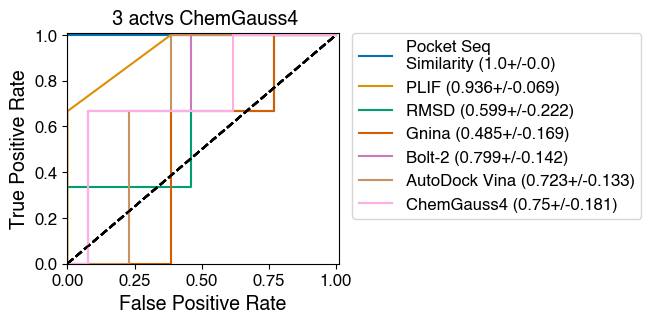

In [ ]:
import seaborn as sns
fig, axs = plt.subplots(1, 1, figsize=(3.5, 3))

labels = ['Pocket Seq\nSimilarity', 'PLIF', 'RMSD', 'Gnina', 'Bolt-2','AutoDock Vina', 'ChemGauss4', ]
cols = ['Bsite-seq-identity', 'ByInteractionTypeAndResidueType', 'RMSD', 'CNN_dock_affinity', 'boltz2-pIC50', 'Vina-score-premin', 'docking-score-POSIT', ] 

signs = [1]*len(labels)
signs[-2] *= -1
signs[-1] *= -1
colors = list(sns.color_palette("colorblind"))
title = lambda x: f" {np.count_nonzero(df_all_b['signal']>x)} actvs"
for label, col, color, sign in zip(labels, cols, colors, signs):
    ax1 = get_roc_curve(axs, df_all_b[col]*sign, df_all_b['signal'] > 50, pred_type=label, title=title(50), n_bootstraps=500, color=color, box=False, legend=True)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()

## Plotting prospective results

Group: 229E
Group: CDPHE15
Group: CHB25
Group: HKU1
Group: HKU11
Group: HKU15
Group: HKU19
Group: HKU33
Group: HKU8
Group: HKU9
Group: Lucheng
Group: MERS-CoV
Group: NL63
Group: OC43
Group: SARS-CoV-1
Group: SARS-CoV-2


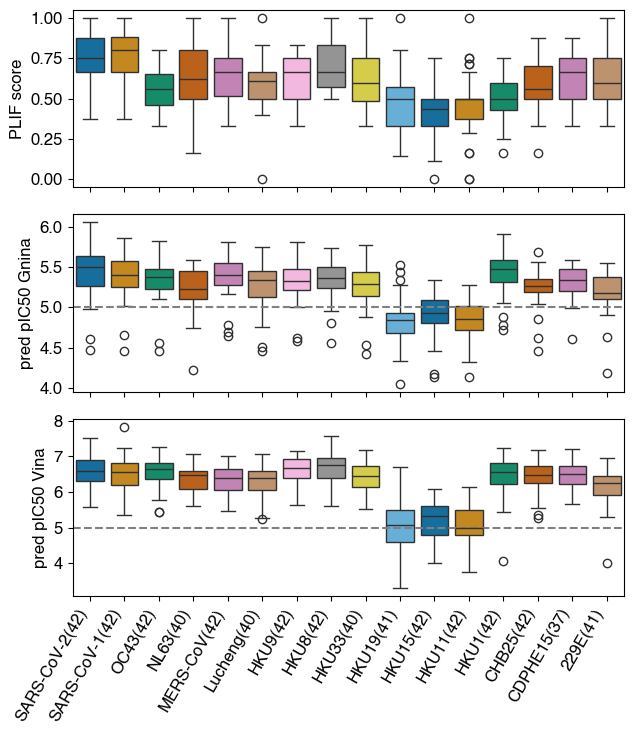

In [ ]:
all_ligands_scores = pd.read_csv("data/prospective_scores.csv")

import matplotlib
matplotlib.rcParams['font.family'] = ['Helvetica']

def pic50_from_dG(dG):
    return -np.log10(np.exp(dG/0.5922))


grouped = all_ligands_scores.groupby('blast-descriptor')
fig, ax = plt.subplots(3, 1, figsize=(6.5, 7.5))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

activity_gnina = []
activity_vina = []
activity_rmsd = []
names = []
pic50s_gnina = []
pic50s_vina = []
fps = []
for name, group in grouped:
    print(f"Group: {name}")
    total = grouped.size()[name]
    # Gnina
    aff_gnina = group['CNNaffinity'].reset_index(drop=True)
    pic50_gnina = pic50_from_dG(-aff_gnina)
    count_active = pic50_gnina[pic50_gnina > 5].count()
    activity_gnina.append(count_active/total)
    pic50s_gnina.append(pic50_gnina.rename(name))
    # Vina
    aff_vina = group['Vina-score-premin'].reset_index(drop=True)
    pic50_vina = pic50_from_dG(aff_vina)
    count_active = pic50_vina[pic50_vina > 5].count()
    activity_vina.append(count_active/total)
    pic50s_vina.append(pic50_vina.rename(name))
    # Fingerprints
    fp = group['ByInteractionTypeAndResidueType'].reset_index(drop=True)
    fps.append(fp.rename(name)) 

    names.append(f"{name}({total})")

fp_df = pd.DataFrame(fps).T
sns.boxplot(data=fp_df[fp_df.columns[::-1]], ax=ax[0], palette='colorblind')
ax[0].set_ylabel("PLIF score")
ax[0].set_xticklabels([])

pic50s_gnina = pd.DataFrame(pic50s_gnina).T
sns.boxplot(pic50s_gnina[pic50s_gnina.columns[::-1]], ax=ax[1], palette='colorblind')
ax[1].axhline(5, color="gray", linestyle="dashed")
ax[1].set_ylabel("pred pIC50 Gnina")
ax[1].set_xticklabels([])

pic50s_vina = pd.DataFrame(pic50s_vina).T
sns.boxplot(data=pic50s_vina[pic50s_vina.columns[::-1]], ax=ax[2], palette='colorblind')
ax[2].axhline(5, color="gray", linestyle="dashed")
ax[2].set_ylabel("pred pIC50 Vina")
ax[2].set_xticklabels(names[::-1], rotation=60, ha="right")

fig.tight_layout()